In [5]:
# %pip install nfoursid

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone
import vaex
from nfoursid.nfoursid import NFourSID

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [7]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 27.01%
Test size ≃ 72.99%


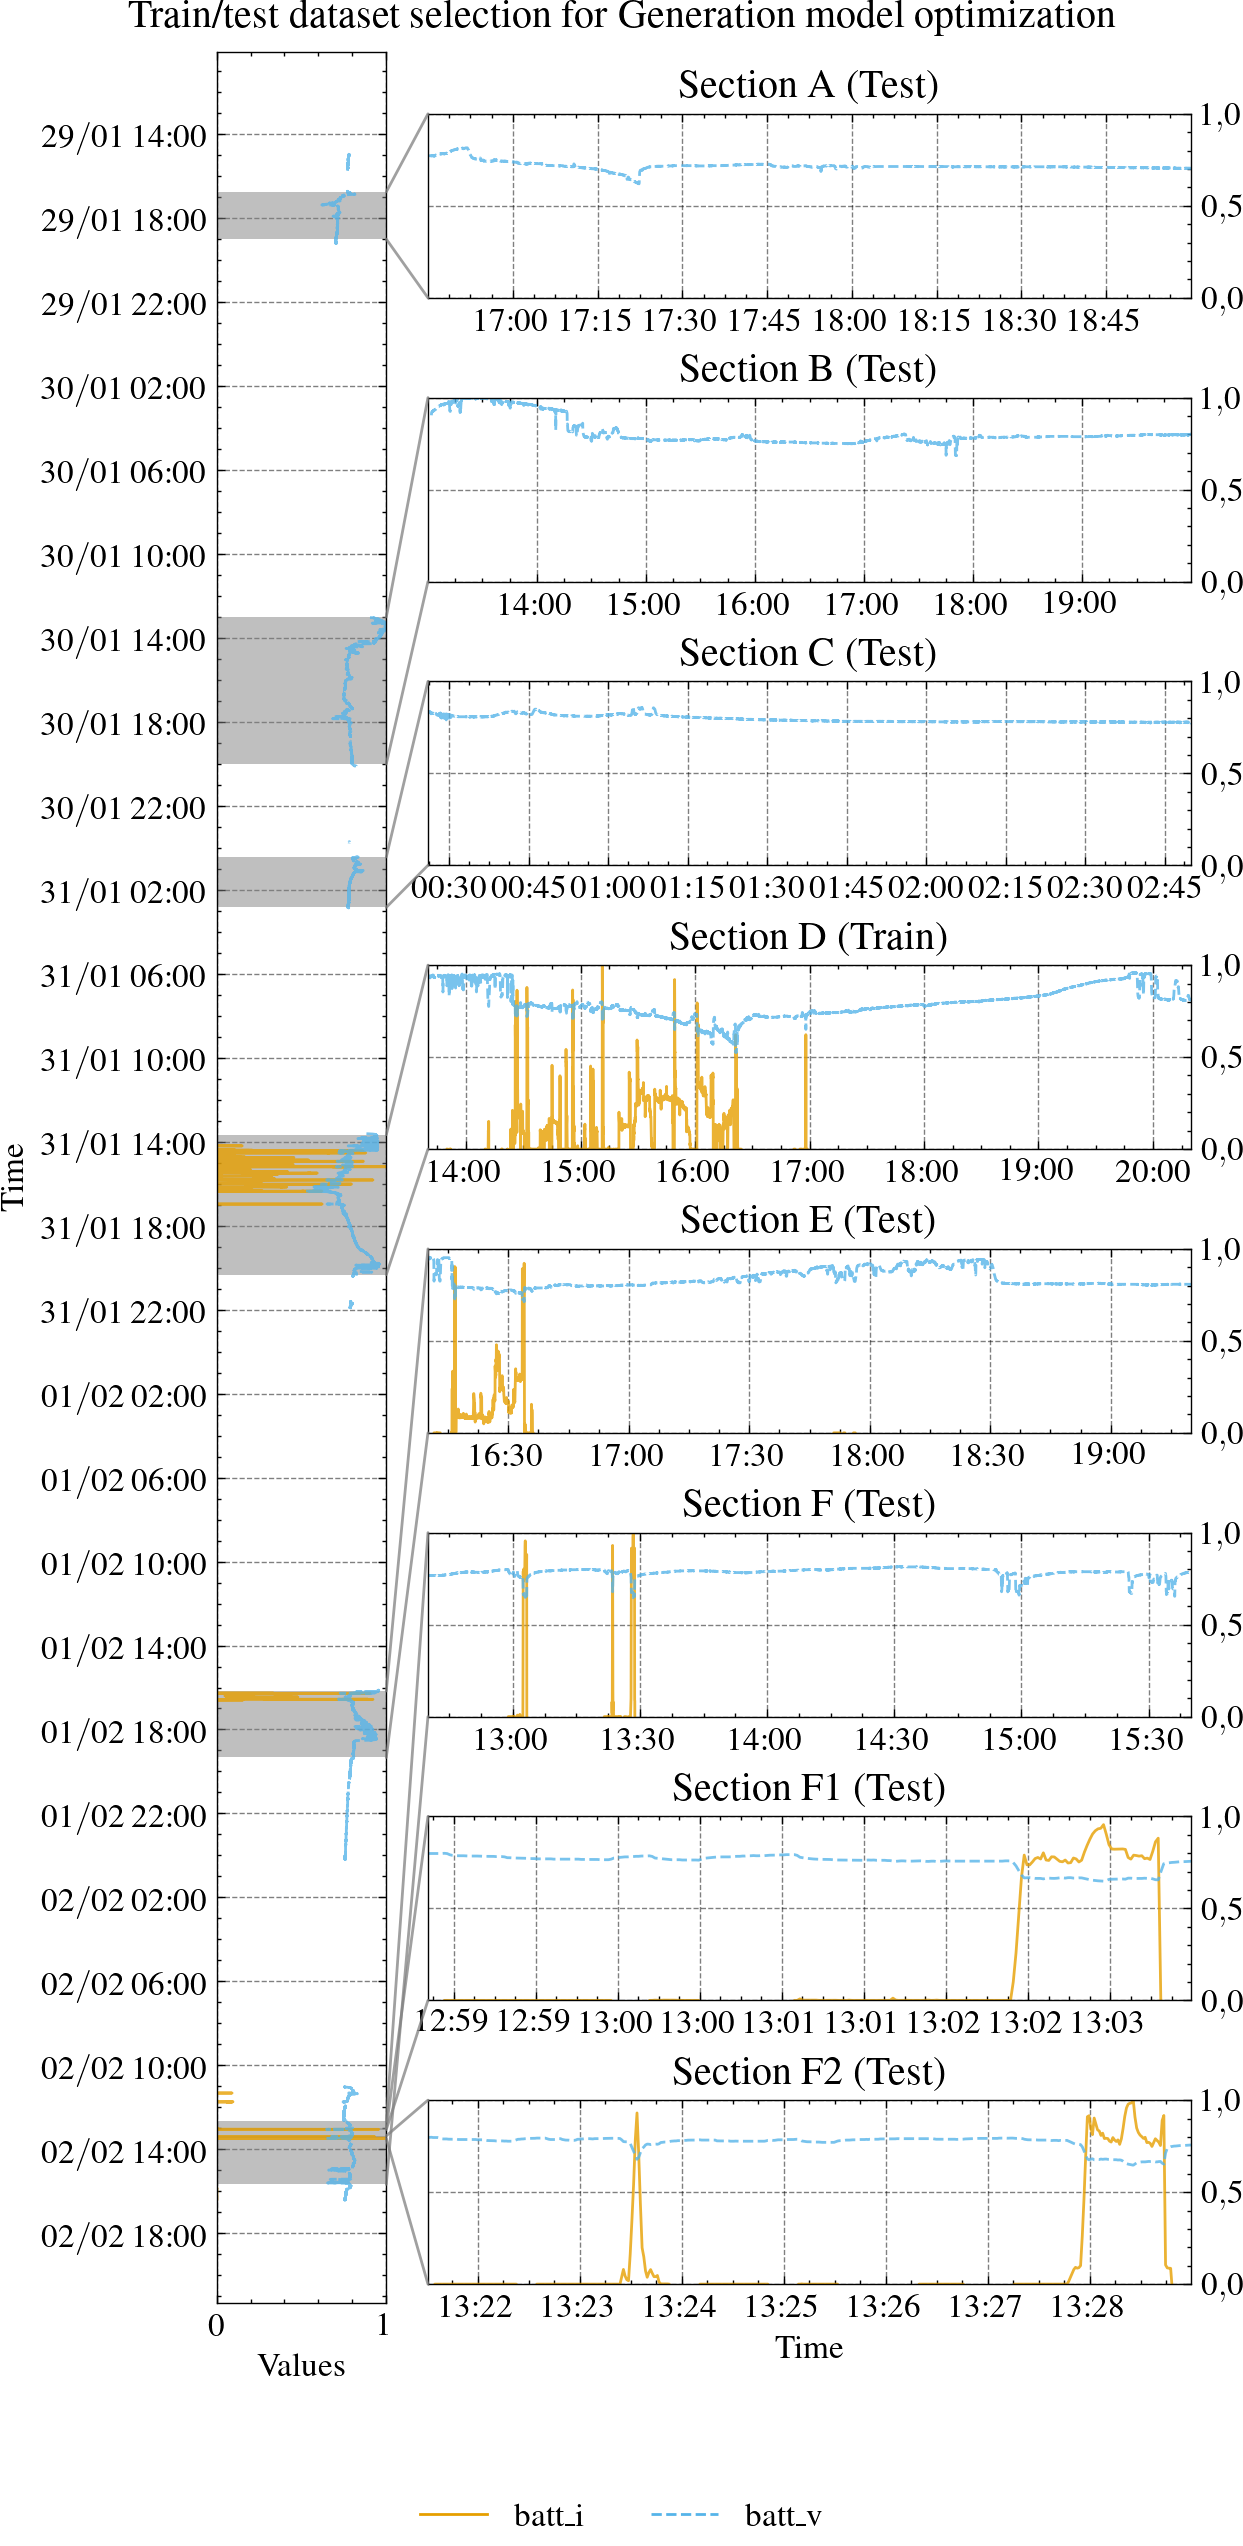

In [8]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    # 'ESC Duty Cycle': 'pilot_d',
    # 'Motor Angular Speed': 'motor_w',
    # 'ESC Input Power': 'esc_p_in',
    # 'ESC Input Current': 'esc_i_in',
    # **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    # **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    # **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    # 'MPPTs Output Current': 'mppts_i_out',
    # 'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
# sections = sections.loc[['Section D', 'Section E', 'Section F1', 'Section F2']]

# sections = sections.loc[['Section D', 'Section E', 'Section F']]
train_section_name = 'Section D'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )


# Optimization

In [9]:
from nfoursid.nfoursid import NFourSID

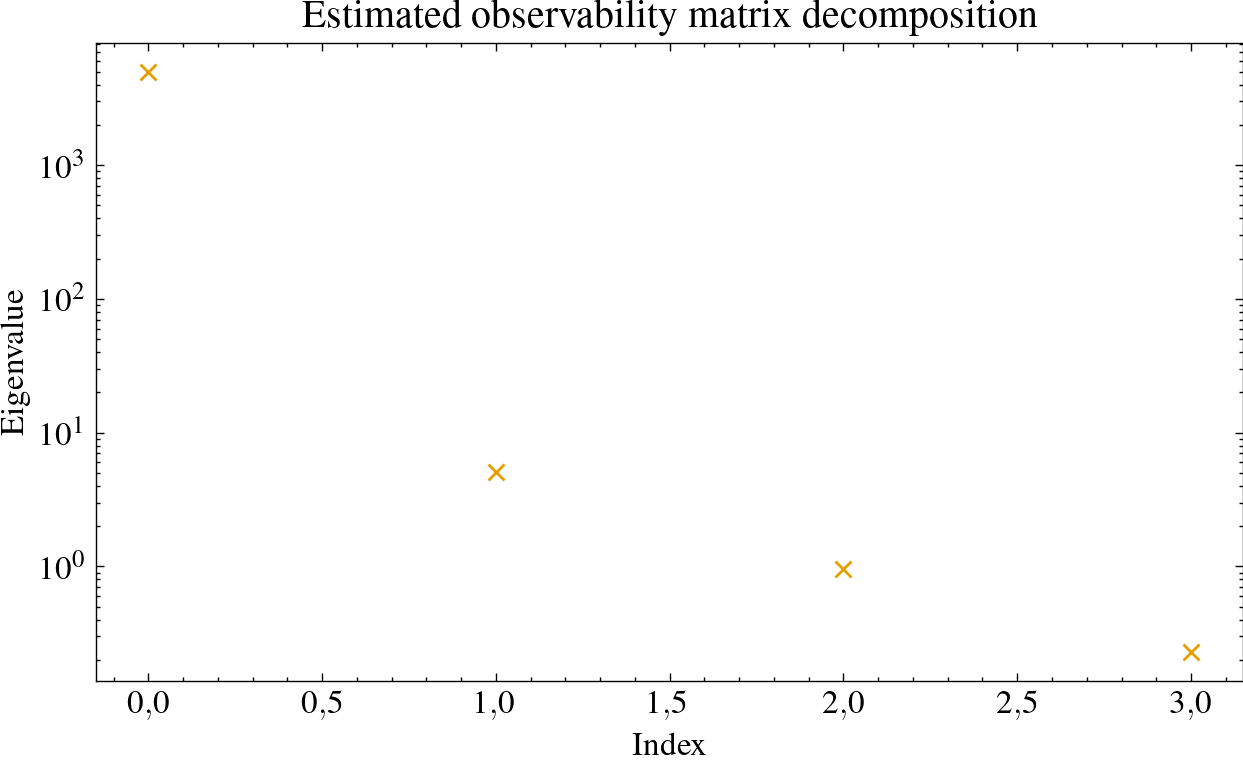

CPU times: user 453 ms, sys: 459 ms, total: 912 ms
Wall time: 398 ms


In [128]:
%%time
## BATTERY OPTIMIZATION

# Select the optimization data
data_cols = ['batt_v']
input_cols = ['batt_i', 'batt_z']

# Put simulation data into df
df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]
# df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols].resample('1min').mean().interpolate(method='time')
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
df_train['batt_z'] -= (df_train['batt_z'].max()-1)
df_train['batt_z'] -= df_train['batt_z'].min()

# Create and identify the model
nfoursid = NFourSID(
    df_train,
    output_columns=data_cols,
    input_columns=input_cols,
    num_block_rows=4
)
nfoursid.subspace_identification()

fig, ax = plt.subplots()
nfoursid.plot_eigenvalues(ax)
plt.show()

In [152]:
ORDER_OF_MODEL_TO_FIT = 3
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

import control as ct

battery = ct.StateSpace(
    state_space_identified.a,
    state_space_identified.b,
    state_space_identified.c,
    state_space_identified.d,
    inputs=('batt_i', 'batt_z'),
    outputs=('batt_v',),
    dt=1,
)
display(battery)


StateSpace(array([[ 0.99951091,  0.03877032, -0.00897918],
       [ 0.00809308,  0.32676093,  0.06926858],
       [-0.00499024,  0.40913974,  0.38081662]]), array([[ 7.53499804e-05,  1.16700800e-05],
       [-1.25479727e-03,  1.85200423e-05],
       [ 7.59485426e-04, -1.21675984e-04]]), array([[-55.06777219,   4.81057844,  -0.17170537]]), array([[-0.02444165, -0.00045888]]), 1)

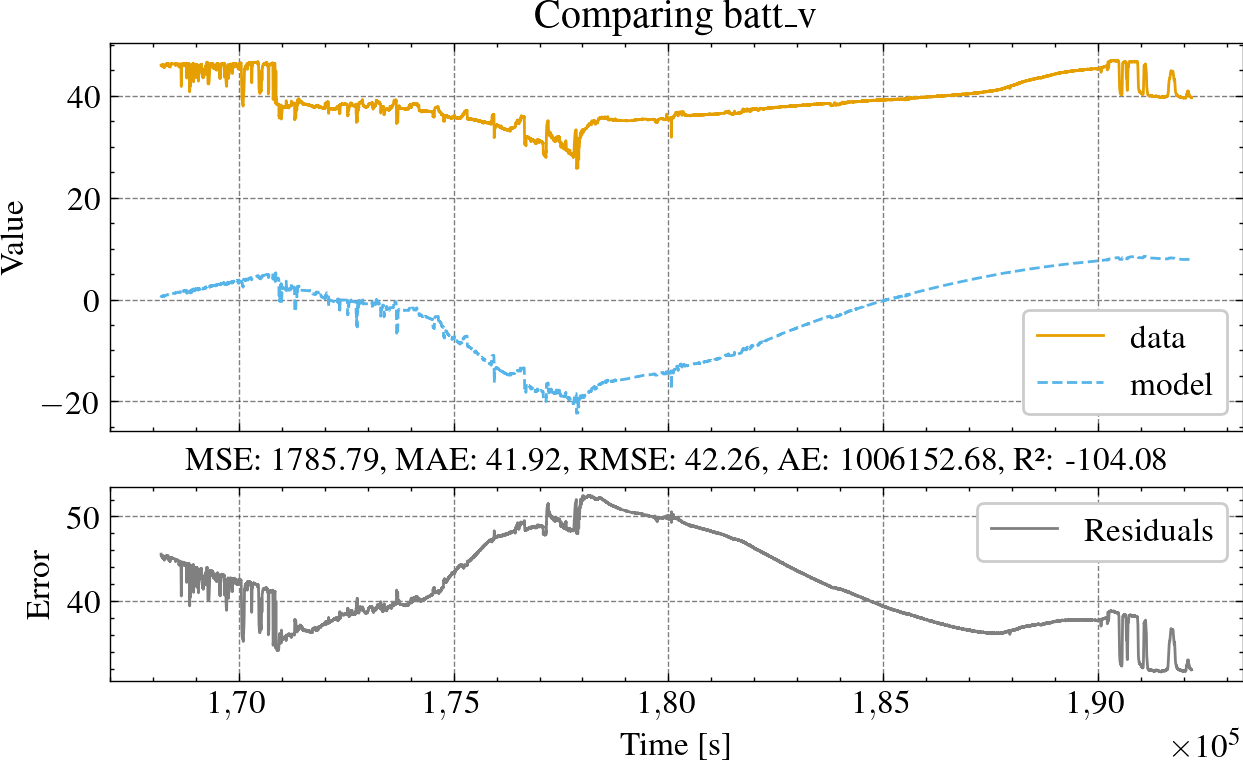

In [153]:
# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i', 'batt_z']].to_numpy().T

# Initial state
X0 = np.zeros(ORDER_OF_MODEL_TO_FIT)

res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
best_fit_data = res.to_pandas().set_index("time")

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)


In [160]:
import numpy as np
import pandas as pd
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.sampling.lhs import LHS
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from multiprocessing import Pool


# --- Prepare Data and Define Simulation Parameters ---

# Time array and input are taken from your training DataFrame.
T = df_train['t'].to_numpy()
U = df_train[['batt_i', 'batt_z']].to_numpy().T

# Assume that the measured output you want to match is given by the 'batt_v' column.
measured_batt_v = df_train['batt_v'].to_numpy()

# 'battery' is your dynamical system model and ct.input_output_response is assumed available.
# For example, the simulation is performed as follows:
#   res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
#   sim_data = res.to_pandas().set_index("time")
# In this example the simulation is wrapped inside the objective function.


# --- Define the Objective Function ---

def simulation_error(x0_candidate):
    """
    Given a candidate initial state vector x0_candidate (a 1D numpy array with 3 elements),
    simulate the battery response and compute the mean-squared error (MSE)
    between the simulated batt_v and the measured batt_v.
    """
    # Run the simulation with the candidate initial state.
    res = ct.input_output_response(battery, T=T, U=U, X0=x0_candidate, solve_ivp_method='Radau')
    sim_data = res.to_pandas().set_index("time")

    # Here we assume that the simulation result contains a column 'batt_v'.
    sim_batt_v = sim_data['batt_v'].to_numpy()

    # Compute the mean squared error between simulated and measured batt_v.
    mse = np.mean((sim_batt_v - measured_batt_v) ** 2)
    return mse


# --- Define the pymoo Problem ---

class BatteryInitStateProblem(ElementwiseProblem):
    def __init__(self, elementwise_runner):
        # Here we have 3 decision variables (for X0) and 1 objective (the error).
        # The lower and upper bounds (xl and xu) are set here as an example.
        # You should adjust these bounds to reflect realistic values for your system.
        super().__init__(n_var=ORDER_OF_MODEL_TO_FIT,
                         n_obj=1,
                         n_constr=0,
                         xl=np.array([-100]*ORDER_OF_MODEL_TO_FIT),
                         xu=np.array([100]*ORDER_OF_MODEL_TO_FIT),
                         elementwise_evaluation=True,
                         elementwise_runner=elementwise_runner)

    def _evaluate(self, x, out, *args, **kwargs):
        # x is a candidate vector (of length 3).
        error = simulation_error(x)
        out["F"] = error


# --- Set Up and Run the Optimization Using Differential Evolution ---

n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Create an instance of the problem.
problem = BatteryInitStateProblem(elementwise_runner=runner)

# Set up the DE algorithm. Here we use a population size of 50 and the
# 'DE/rand/1/bin' variant. You can adjust algorithm hyperparameters as needed.
algorithm = DE(
    pop_size=10*ORDER_OF_MODEL_TO_FIT,
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=10000,
    n_max_evals=100000
)

# Run the optimization for 100 generations.
res = minimize(problem,
               algorithm,
               termination=('n_gen', 100),
               seed=1,
               verbose=True)

# Display the results.
print("Best initial state (X0) found:")
print(res.X)
print("Minimum mean squared error achieved:")
print(res.F)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  6.142125E+06 |  4.601252E+04
     2 |       60 |  3.064319E+06 |  3.946872E+02
     3 |       90 |  1.280516E+06 |  3.946872E+02
     4 |      120 |  6.052743E+05 |  3.946872E+02
     5 |      150 |  1.633404E+05 |  3.946872E+02
     6 |      180 |  5.238073E+04 |  2.418975E+02
     7 |      210 |  1.164931E+04 |  5.806206E+01
     8 |      240 |  5.167676E+03 |  5.806206E+01
     9 |      270 |  1.975310E+03 |  5.806206E+01
    10 |      300 |  9.558474E+02 |  5.806206E+01
    11 |      330 |  6.633287E+02 |  5.660873E+01
    12 |      360 |  3.371888E+02 |  5.228634E+01
    13 |      390 |  1.476716E+02 |  5.018741E+01
    14 |      420 |  8.285388E+01 |  5.018741E+01
    15 |      450 |  6.929559E+01 |  5.018741E+01
    16 |      480 |  6.166652E+01 |  5.018741E+01
    17 |      510 |  5.675375E+01 |  4.989624E+01
    18 |      540 |  5.315390E+01 |  4.946430E+01
    19 |      570 |  5.169159E+01 |  4.784628E+01


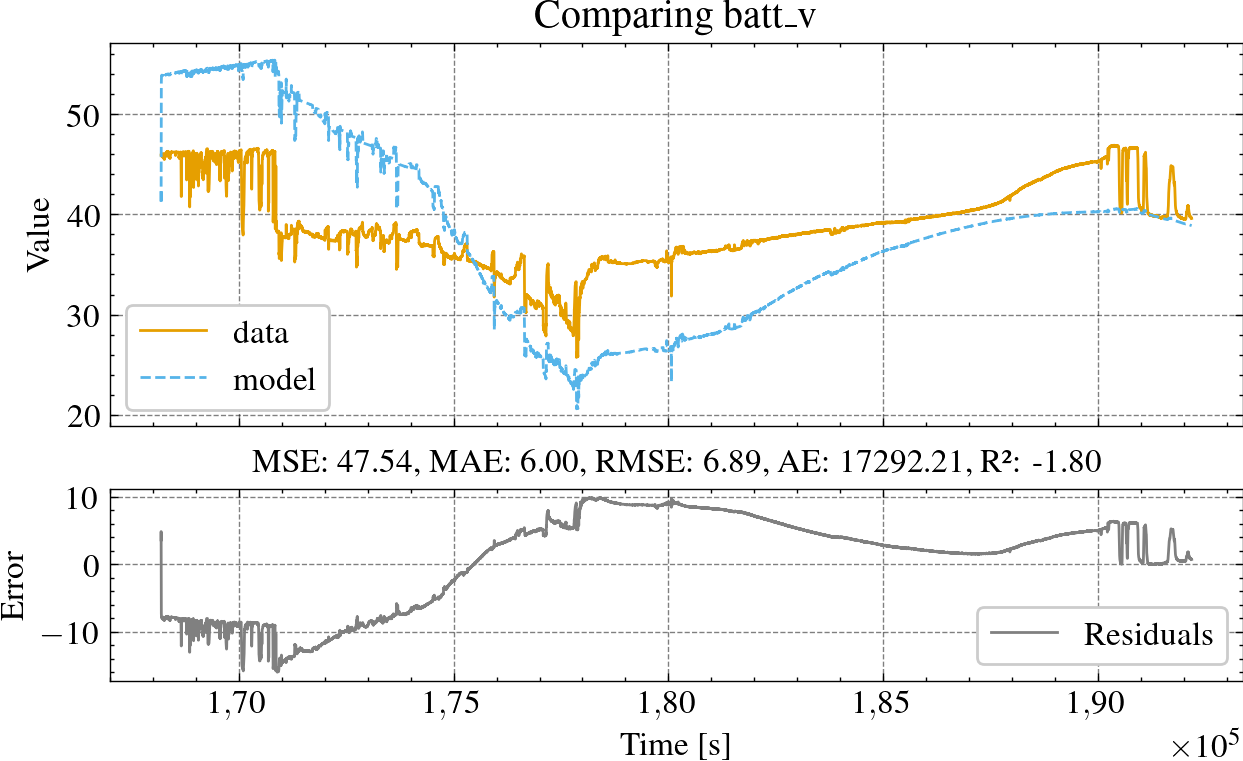

In [161]:
# Time array
T = df_train['t'].to_numpy()

# Inputs
U = df_train[['batt_i', 'batt_z']].to_numpy().T

# Initial state
X0 = res.X

res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
best_fit_data = res.to_pandas().set_index("time")

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)
